In [4]:
import json
import math

# Load the disorders JSON file
def load_disorders(json_file):
    with open(json_file, 'r', encoding='utf-8') as f:
        disorders = json.load(f)
    return disorders

# Helper function to parse frequency strings into a numeric value
def parse_frequency(freq_str):
    if freq_str is None:
        return 0.5
    if "Very frequent" in freq_str:
        return 0.9
    elif "Frequent" in freq_str:
        return 0.6
    elif "Occasional" in freq_str:
        return 0.2
    else:
        return 0.5

disorders = load_disorders('./disorders.json')
print("Loaded", len(disorders), "disorders.")

# Build dictionaries for nodes and accumulate disease->phenotype associations
phenotype_dict = {}  # key: hpo_id, value: {'term': ..., 'frequency': ...}
disease_dict = {}    # key: disease id (using OrphaCode), value: {'name': ...}
disease_to_pheno_edges = []  # List of tuples: (disease_id, hpo_id, weight)

for disorder in disorders:
    disease_id = disorder.get('orpha_code')
    disease_name = disorder.get('name')
    if disease_id not in disease_dict:
        disease_dict[disease_id] = {'name': disease_name}
    
    for pheno in disorder.get('phenotypes', []):
        hpo_id = pheno.get('hpo_id')
        hpo_term = pheno.get('HPOTerm') or pheno.get('hpo_term')
        freq_str = pheno.get('frequency')
        freq_val = parse_frequency(freq_str)
        
        if hpo_id not in phenotype_dict:
            phenotype_dict[hpo_id] = {'term': hpo_term, 'frequency': freq_val}
        
        # Append the disease-to-phenotype edge with the frequency as weight
        disease_to_pheno_edges.append((disease_id, hpo_id, freq_val))

print("Total unique phenotypes:", len(phenotype_dict))
print("Total unique diseases:", len(disease_dict))

Loaded 4283 disorders.
Total unique phenotypes: 8600
Total unique diseases: 4283


In [7]:
import json
with open('disorders.json','r') as f:
    data=json.load(f)
print(json.dumps(data[:1], indent=4))

[
    {
        "orpha_code": "58",
        "name": "Alexander disease",
        "type": "Disease",
        "phenotypes": [
            {
                "hpo_id": "HP:0000256",
                "hpo_term": "Macrocephaly",
                "frequency": "Very frequent (99-80%)"
            },
            {
                "hpo_id": "HP:0001249",
                "hpo_term": "Intellectual disability",
                "frequency": "Very frequent (99-80%)"
            },
            {
                "hpo_id": "HP:0001250",
                "hpo_term": "Seizure",
                "frequency": "Very frequent (99-80%)"
            },
            {
                "hpo_id": "HP:0001257",
                "hpo_term": "Spasticity",
                "frequency": "Very frequent (99-80%)"
            },
            {
                "hpo_id": "HP:0001274",
                "hpo_term": "Agenesis of corpus callosum",
                "frequency": "Very frequent (99-80%)"
            },
            {
        

In [9]:


import pickle
import torch
from torch_geometric.data import HeteroData
import math
import obonet

# (Optional) Placeholder for HPO hierarchy edges; replace with real data if available.
def get_hpo_hierarchy_edges(obo_file='hp.obo'):
    
    graph = obonet.read_obo(obo_file)
    hierarchy_edges=[]
    for node in graph.nodes():
        # Each node's 'is_a' attribute contains its parent terms (if any)
        if 'is_a' in graph.nodes[node]:
            for parent in graph.nodes[node]:
                hierarchy_edges.append((node,parent))
    return hierarchy_edges



# Create the HeteroData object
data = HeteroData()

# --- Add Phenotype Nodes ---
# Each phenotype node gets a feature vector: [frequency, IC] where IC = -log(frequency)
phenotype_list = list(phenotype_dict.keys())
phenotype_features = []
for hpo_id in phenotype_list:
    freq = phenotype_dict[hpo_id]['frequency']
    ic = -math.log(freq)
    phenotype_features.append([freq, ic])
data['phenotype'].x = torch.tensor(phenotype_features, dtype=torch.float)

# --- Add Disease Nodes ---
# Create a dummy feature vector for disease nodes (initially 1-dimensional)
disease_list = list(disease_dict.keys())
disease_features = [[1.0] for _ in disease_list]
disease_features = torch.tensor(disease_features, dtype=torch.float)
# Expand disease node features from 1D to 2D to match phenotype nodes (e.g., simply repeat the feature)
if disease_features.shape[1] == 1:
    disease_features = disease_features.repeat(1, 2)
data['disease'].x = disease_features

# Create mapping from IDs to indices for each node type
pheno_to_idx = {hpo_id: i for i, hpo_id in enumerate(phenotype_list)}
disease_to_idx = {d_id: i for i, d_id in enumerate(disease_list)}

# --- Add Edges: Disease -> Phenotype ---
src, dst, edge_weights = [], [], []
for disease_id, hpo_id, weight in disease_to_pheno_edges:
    if disease_id in disease_to_idx and hpo_id in pheno_to_idx:
        src.append(disease_to_idx[disease_id])
        dst.append(pheno_to_idx[hpo_id])
        edge_weights.append([weight])
data['disease', 'has_phenotype', 'phenotype'].edge_index = torch.tensor([src, dst], dtype=torch.long)
data['disease', 'has_phenotype', 'phenotype'].edge_attr = torch.tensor(edge_weights, dtype=torch.float)

# --- Add Reverse Edges: Phenotype -> Disease ---
data['phenotype', 'associated_with', 'disease'].edge_index = torch.tensor([dst, src], dtype=torch.long)
data['phenotype', 'associated_with', 'disease'].edge_attr = torch.tensor(edge_weights, dtype=torch.float)

# --- (Optional) Add HPO Hierarchy Edges: Phenotype -> Phenotype ---
hpo_hierarchy_edges = get_hpo_hierarchy_edges('hp.obo')
if hpo_hierarchy_edges:
    src_h, dst_h, hierarchy_weights = [], [], []
    for child, parent in hpo_hierarchy_edges:
        if child in pheno_to_idx and parent in pheno_to_idx:
            src_h.append(pheno_to_idx[child])
            dst_h.append(pheno_to_idx[parent])
            hierarchy_weights.append([1.0])
    data['phenotype', 'is_a', 'phenotype'].edge_index = torch.tensor([src_h, dst_h], dtype=torch.long)
    data['phenotype', 'is_a', 'phenotype'].edge_attr = torch.tensor(hierarchy_weights, dtype=torch.float)

print("Heterogeneous graph created:")
print(data)

ModuleNotFoundError: No module named 'obonet'

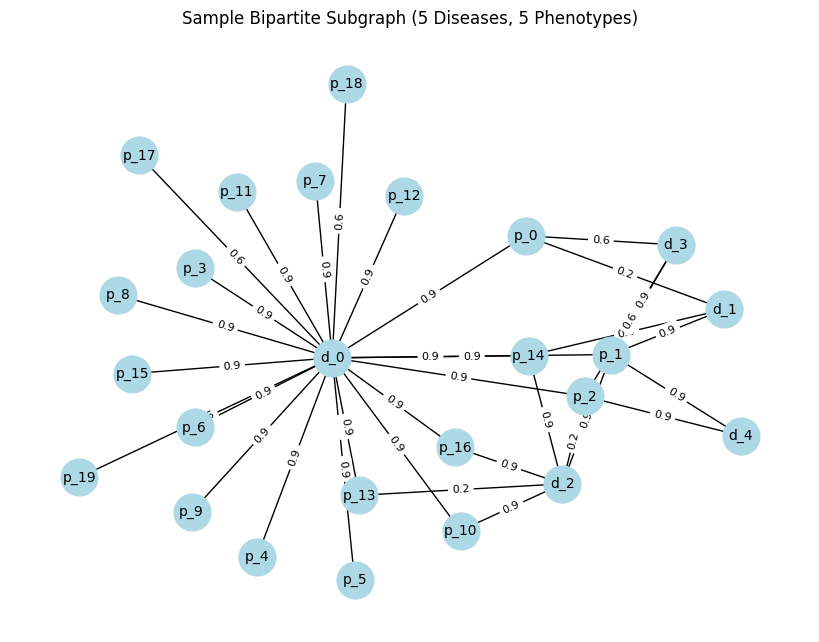

In [35]:
import networkx as nx
import matplotlib.pyplot as plt
import torch

# --- Select a small subgraph for visualization ---
# Choose the first 5 disease nodes and the first 5 phenotype nodes.
num_disease = min(5, data['disease'].num_nodes)
num_phenotype = min(20, data['phenotype'].num_nodes)

selected_disease_idx = list(range(num_disease))
selected_phenotype_idx = list(range(num_phenotype))

# Create a new bipartite NetworkX graph
B = nx.Graph()

# Add disease nodes with a prefix "d_" for clarity
for d in selected_disease_idx:
    # For disease nodes, we use the dummy feature value (here a constant 1.0)
    # .item() converts the tensor to a Python scalar.
    B.add_node(f"d_{d}", bipartite=0, label=f"1.0")

# Add phenotype nodes with a prefix "p_"
for p in selected_phenotype_idx:
    # For phenotype nodes, we display both frequency and IC values
    freq, ic = data['phenotype'].x[p].tolist()
    B.add_node(f"p_{p}", bipartite=1, label=f"f:{freq:.2f}\nic:{ic:.2f}")

# Get the disease -> phenotype edge_index and edge_attr from the heterogeneous graph
edge_index = data['disease', 'has_phenotype', 'phenotype'].edge_index
edge_attr = data['disease', 'has_phenotype', 'phenotype'].edge_attr

# Convert edge_index to numpy for easy iteration
edge_index_np = edge_index.cpu().numpy()

# Add edges only if they connect selected disease and phenotype nodes
for i in range(edge_index_np.shape[1]):
    d_idx = edge_index_np[0, i]
    p_idx = edge_index_np[1, i]
    if d_idx in selected_disease_idx and p_idx in selected_phenotype_idx:
        weight = edge_attr[i].item()
        B.add_edge(f"d_{d_idx}", f"p_{p_idx}", weight=float(f"{weight:.4f}"))

# Visualize the bipartite subgraph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(B, seed=42)
nx.draw(B, pos, with_labels=True, node_size=700, node_color='lightblue', font_size=10)
edge_labels = nx.get_edge_attributes(B, 'weight')
nx.draw_networkx_edge_labels(B, pos, edge_labels=edge_labels, font_size=8)
plt.title("Sample Bipartite Subgraph (5 Diseases, 5 Phenotypes)")
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, HeteroConv

# Define the improved heterogeneous GAT encoder with add_self_loops disabled.
class HeteroGAT(nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, heads=4, dropout=0.3):
        """
        metadata: tuple (node_types, edge_types) from data.metadata()
        hidden_channels: hidden dimension for the GAT layers
        out_channels: final embedding dimension (for all node types)
        heads: number of attention heads
        dropout: dropout rate
        """
        super(HeteroGAT, self).__init__()
        self.dropout = dropout
        
        # First layer: Create a GATConv for each edge type with dropout and no self-loops.
        conv_dict = {}
        for edge_type in metadata[1]:
            conv_dict[edge_type] = GATConv(-1, hidden_channels, heads=heads, concat=True,
                                            dropout=dropout, add_self_loops=False)
        self.conv1 = HeteroConv(conv_dict, aggr='sum')
        
        # Second layer: Map from (hidden_channels * heads) to out_channels.
        conv_dict2 = {}
        for edge_type in metadata[1]:
            conv_dict2[edge_type] = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False,
                                            dropout=dropout, add_self_loops=False)
        self.conv2 = HeteroConv(conv_dict2, aggr='sum')
    
    def forward(self, x_dict, edge_index_dict):
        # Save input for residual connection
        x_dict_in = x_dict
        # First GAT layer with ELU activation
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.gelu(x) for key, x in x_dict.items()}
        # Optional residual connection (only if dimensions match)
        for key in x_dict:
            if x_dict_in[key].shape[-1] == x_dict[key].shape[-1]:
                x_dict[key] = x_dict[key] + x_dict_in[key]
        # Second GAT layer produces final embeddings (call only once)
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

# Define the heterogeneous autoencoder that wraps the encoder and adds decoders for each node type.
class HeteroAutoencoderGAT(nn.Module):
    def __init__(self, metadata, hidden_channels, embedding_dim, out_channels_dict, heads=4, dropout=0.3):
        """
        metadata: tuple (node_types, edge_types) from data.metadata()
        hidden_channels: hidden dimension for the GAT layers
        embedding_dim: final embedding dimension (for all node types)
        out_channels_dict: dictionary mapping each node type to its original feature dimension
        heads: number of attention heads
        dropout: dropout rate
        """
        super(HeteroAutoencoderGAT, self).__init__()
        self.encoder = HeteroGAT(metadata, hidden_channels, embedding_dim, heads=heads, dropout=dropout)
        # Create a decoder (linear layer) for each node type to reconstruct the original features.
        self.decoders = nn.ModuleDict()
        for node_type in metadata[0]:
            self.decoders[node_type] = nn.Linear(embedding_dim, out_channels_dict[node_type])
    
    def forward(self, data):
        # Encode: Get embeddings for each node type.
        x_dict = self.encoder(data.x_dict, data.edge_index_dict)
        # Decode: Reconstruct original features for each node type.
        reconstructions = {}
        for node_type, x in x_dict.items():
            reconstructions[node_type] = self.decoders[node_type](x)
        return x_dict, reconstructions

In [37]:
import torch.optim as optim

# Define original feature dimensions:
# - Phenotype nodes have 2 features: [frequency, IC]
# - Disease nodes have been expanded to 2 features (dummy features)
out_channels_dict = {'phenotype': 2, 'disease': 2}

# Get metadata from the heterogeneous graph (assuming 'data' is already created)
metadata = data.metadata()  # Returns (node_types, edge_types)

# Initialize the improved GAT-based autoencoder model.
hidden_channels = 32    # Increased hidden dimension
embedding_dim = 32      # Increased embedding dimension
heads = 4
dropout = 0.3
model = HeteroAutoencoderGAT(metadata, hidden_channels, embedding_dim, out_channels_dict, heads=heads, dropout=dropout)

# Set up the optimizer and loss criterion (MSE).
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

# Training loop: Train the autoencoder to reconstruct node features.
model.train()
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    x_dict, reconstructions = model(data)
    loss = 0
    # Sum the reconstruction loss for each node type.
    for node_type in data.node_types:
        loss += criterion(reconstructions[node_type], data[node_type].x)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

print("Training complete.")

Epoch 50/1000, Loss: 0.2451
Epoch 100/1000, Loss: 0.2108
Epoch 150/1000, Loss: 0.2079
Epoch 200/1000, Loss: 0.2028
Epoch 250/1000, Loss: 0.1989
Epoch 300/1000, Loss: 0.1973
Epoch 350/1000, Loss: 0.1965
Epoch 400/1000, Loss: 0.1962
Epoch 450/1000, Loss: 0.1975
Epoch 500/1000, Loss: 0.1978
Epoch 550/1000, Loss: 0.1994
Epoch 600/1000, Loss: 0.1978
Epoch 650/1000, Loss: 0.1987
Epoch 700/1000, Loss: 0.1965
Epoch 750/1000, Loss: 0.1969
Epoch 800/1000, Loss: 0.1988
Epoch 850/1000, Loss: 0.1977
Epoch 900/1000, Loss: 0.1973
Epoch 950/1000, Loss: 0.1966
Epoch 1000/1000, Loss: 0.1968
Training complete.


In [26]:
# Set the model to evaluation mode and extract embeddings from the encoder.
model.eval()
with torch.no_grad():
    embeddings = model.encoder(data.x_dict, data.edge_index_dict)

# Print the shape of embeddings for each node type.
for node_type, emb in embeddings.items():
    print(f"{node_type} embeddings shape: {emb.shape}")

# Save the learned embeddings to a file.
torch.save(embeddings, "hetero_node_embeddings_gat_improved.pt")
print("Heterogeneous node embeddings (improved GAT) saved as 'hetero_node_embeddings_gat_improved.pt'")

phenotype embeddings shape: torch.Size([8600, 32])
disease embeddings shape: torch.Size([4283, 32])
Heterogeneous node embeddings (improved GAT) saved as 'hetero_node_embeddings_gat_improved.pt'


In [27]:
embeddings['phenotype'][0]

tensor([-0.0529, -0.2069,  0.2294, -0.1099,  0.2768, -0.0678,  0.1093,  0.4169,
         0.0838, -0.2457, -0.1317,  0.1134, -0.0085,  0.3174, -0.2002,  0.1622,
        -0.2333,  0.2799,  0.2448,  0.2359,  0.0198,  0.0498,  0.4397, -0.2288,
         0.1005,  0.3717,  0.2620,  0.1798,  0.3789,  0.0669,  0.2009, -0.3073])

In [28]:
embeddings['disease'][0]

tensor([ 0.3347, -0.5583,  0.3116,  0.2994,  0.0041,  0.5220,  0.0167,  0.2749,
        -0.5415, -0.8304, -0.3007,  0.1691,  0.5185, -0.6649,  0.3867,  0.4134,
         0.5002, -0.5672, -0.5708,  0.5923, -0.6389,  0.2953,  0.1434, -0.0719,
         0.4575, -0.8525,  0.4790, -0.3161,  0.5861,  0.2589, -0.1747,  0.3483])

In [29]:

model.eval()
with torch.no_grad():

    phenotype_embedding = embeddings['phenotype'][0]
    reconstructed_features = model.decoders['phenotype'](phenotype_embedding.unsqueeze(0))
    print("Reconstructed phenotype features:", reconstructed_features)

Reconstructed phenotype features: tensor([[0.6605, 0.5359]])
